# Purpose

Ad-hoc test new open-TSNE library to compress & visualize subs.

Use experimentation in this notebook to inform the class/functions that will log & repeat the process in mlflow.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [121]:
from datetime import datetime
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

import subclu
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates

# imports specific to this notebook
import umap
import openTSNE
from openTSNE import TSNE

import sklearn
from sklearn.decomposition import TruncatedSVD


print_lib_versions([np, openTSNE, pd, plotly, sklearn, sns, umap, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
openTSNE	v: 0.6.0
pandas		v: 1.2.4
plotly		v: 4.14.3
sklearn		v: 0.24.1
seaborn		v: 0.11.1
umap		v: 0.5.1
subclu		v: 0.3.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/mlflow/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active


# Set path for saving intermediary files

In [35]:
path_this_model = get_project_subfolder(
    f"data/models/compression/manual_{datetime.utcnow().strftime('%Y-%m-%d_%H_%M')}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/compression/manual_2021-07-16_20_54')

# Load vectors

In [15]:
%%time

run_uuid = 'cf3c6dfb599b414a812085659e62ec85'

d_dfs_mlflow = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
    read_function='json',
)

CPU times: user 262 ms, sys: 38.1 ms, total: 300 ms
Wall time: 476 ms


In [16]:
list(d_dfs_mlflow.keys())

['df_post_level_agg_b_post_and_comments',
 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_b_post_and_comments',
 'df_sub_level_agg_b_post_and_comments_similarity',
 'df_sub_level_agg_b_post_and_comments_similarity_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']

In [17]:
f_embeddings_sub_level = 'df_sub_level_agg_c_post_comments_and_sub_desc'
f_embeddings_post_level = 'df_post_level_agg_c_post_comments_sub_desc'

## Subreddit-level

In [20]:
%%time

df_v_sub = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_embeddings_sub_level,
    read_function='pd_parquet',
)
print(df_v_sub.shape)

(628, 514)
CPU times: user 489 ms, sys: 68.1 ms, total: 557 ms
Wall time: 1.15 s


## Post-level

In [19]:
%%time

df_v_posts = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_embeddings_post_level,
    read_function='pd_parquet',
)
print(df_v_posts.shape)

(262226, 515)
CPU times: user 8.46 s, sys: 5 s, total: 13.5 s
Wall time: 8.98 s


In [21]:
df_v_sub.head()

,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,1fcnuernberg,t5_30jst,-0.008660,-0.006559,-0.028420,-0.012715,-0.017480,0.035704,0.009162,-0.026689,-0.011076,-0.004571,0.017631,-0.014315,-0.001375,0.026188,0.029600,0.012597,-0.023396,-0.013984,0.001590,0.005970,-0.011658,-0.013357,-0.004300,0.012704,-0.002377,0.020705,0.018488,0.001391,...,0.008202,-0.022192,0.018567,0.002488,-0.006712,-0.038519,0.007598,-0.017711,0.032184,-0.016639,0.012579,-0.011595,-0.017459,-0.029349,0.000281,0.008458,0.012068,-0.008986,-0.008736,-0.030438,-0.022983,0.009261,0.015042,0.022384,0.029515,-0.000409,0.011180,-0.019316,0.029088,0.027276
1,3thedward,t5_2eeymn,0.028508,-0.016625,0.001146,-0.002151,-0.028855,0.033304,0.003953,-0.013718,-0.041954,-0.017507,0.000024,0.002529,-0.022066,-0.004750,-0.005232,-0.012752,0.004188,0.000963,0.003016,0.003301,-0.009171,0.036562,-0.020530,0.000608,0.001470,0.014612,0.016101,-0.010159,...,-0.012378,-0.007396,-0.002055,0.010318,0.021053,-0.051431,-0.007610,-0.010048,0.010779,-0.007372,-0.001211,0.023909,-0.009936,-0.023089,-0.009645,0.014979,-0.013598,-0.012381,-0.014107,-0.002002,-0.039499,0.022121,0.034372,0.019086,0.014702,0.002096,-0.013280,0.010011,0.012709,0.025760
2,600euro,t5_3caax,-0.014205,-0.016734,0.000440,-0.006517,-0.010836,0.032220,0.008668,0.005748,-0.036115,-0.005135,-0.000457,-0.000722,0.015559,0.005737,0.008014,-0.001296,-0.009588,-0.016953,-0.008655,0.005002,-0.002266,0.022717,0.016652,0.000527,-0.002286,-0.006137,0.003506,-0.002454,...,0.008259,-0.001171,-0.014981,0.007539,0.002496,-0.054661,-0.013676,-0.000529,0.013986,0.005637,0.006926,0.017856,-0.001603,-0.000526,-0.004451,0.016510,-0.006849,-0.012300,-0.017822,-0.003465,-0.035334,0.007772,0.009091,0.016724,-0.002143,-0.002882,-0.005544,-0.005933,0.007125,0.040743
3,aachen,t5_2t4y2,-0.006774,0.000613,-0.010110,-0.001635,-0.043100,0.034224,0.010758,-0.002212,-0.042381,-0.018985,0.005759,-0.003787,0.028548,0.007767,-0.014934,0.014395,0.001343,-0.023469,0.013139,-0.004277,-0.012801,0.006537,0.023975,0.007930,0.014603,0.001775,-0.000046,-0.005390,...,0.014112,-0.008488,-0.009263,0.016614,-0.008486,-0.048655,-0.012890,-0.020162,0.030393,-0.017855,0.010740,-0.010496,-0.005497,-0.016685,-0.013883,0.021075,0.015082,-0.002745,-0.007618,0.004971,-0.041154,-0.017621,-0.001701,-0.011653,-0.006990,-0.003633,-0.009221,-0.036380,0.008990,0.046404
4,aeiou,t5_2qmr6,0.009972,-0.003391,-0.006674,0.017235,-0.018784,0.031920,0.001665,-0.013690,-0.041176,0.000270,-0.003018,0.003741,0.001480,-0.008902,-0.004855,0.010978,-0.016408,-0.012709,0.002892,0.012965,-0.012167,0.016544,0.008354,0.017980,-0.006000,-0.008740,0.006924,-0.000056,...,0.018518,-0.016065,0.004551,0.011253,0.013024,-0.055018,-0.011716,0.013769,0.027255,-0.005829,-0.008197,0.019103,-0.010732,-0.016241,-0.002277,0.014516,-0.005284,-0.020327,-0.013826,-0.009149,-0.037515,0.006547,0.014154,0.021759,0.006371,-0.005358,0.001370,-0.015838,0.007994,0.035158


In [22]:
df_v_posts.head()

,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,1fcnuernberg,t5_30jst,t3_mjwbjc,-0.035099,-0.026923,-0.034513,-0.033560,-0.062294,-0.001953,0.024750,-0.031606,0.023013,0.001710,0.035320,-0.045273,-0.038995,0.051005,0.036159,0.059378,-0.034993,-0.005673,0.023401,0.009704,0.028911,-0.064812,-0.007975,-0.014361,-0.002511,0.055428,0.019065,...,-0.019423,-0.040371,0.027682,0.019759,-0.000905,-0.011388,0.035403,-0.040394,0.021277,0.004153,0.007607,0.016996,-0.037660,-0.042258,0.021173,0.015737,0.002301,-0.000558,0.044235,-0.058138,-0.001251,-0.019134,-0.006640,0.033963,0.018584,0.010524,0.050073,-0.019815,0.035839,0.034813
1,1fcnuernberg,t5_30jst,t3_mjwik7,0.039519,0.029168,0.005505,0.035246,0.016160,0.018877,-0.014360,0.013581,-0.060335,-0.021574,-0.007448,-0.005513,0.069930,-0.004905,0.042485,0.005615,0.027415,-0.043557,-0.043875,0.052669,-0.002233,0.046310,-0.066946,-0.054245,0.055125,0.014134,0.052472,...,-0.030485,-0.049312,0.007180,-0.006391,0.021513,-0.047082,0.005128,0.026080,0.002058,-0.078898,-0.022535,-0.001865,0.025624,-0.050256,0.037816,0.022684,0.062925,-0.055776,-0.012895,-0.029526,0.016569,0.019123,0.045878,-0.009120,-0.006636,0.004824,-0.016368,0.026101,-0.015786,0.089142
2,1fcnuernberg,t5_30jst,t3_mm8azo,-0.040873,0.059453,0.023355,-0.043328,-0.004095,0.031226,-0.046035,0.027530,-0.013499,0.039407,-0.013603,-0.001700,0.003055,-0.025698,0.073403,-0.019236,-0.060356,-0.035750,-0.013764,0.013492,-0.069227,0.028043,0.030743,-0.006857,-0.011968,-0.018153,0.027360,...,0.026028,-0.036360,0.001612,0.011413,0.018252,-0.040409,0.002866,-0.036714,-0.006005,-0.045536,-0.006411,-0.002929,0.020841,-0.046652,0.059424,-0.041656,0.025706,-0.058474,-0.064581,0.005493,-0.053104,0.058165,0.037117,0.051078,0.063035,-0.051998,0.029449,0.023221,0.054630,-0.062919
3,1fcnuernberg,t5_30jst,t3_moqu14,-0.036370,0.049475,-0.063051,-0.059340,-0.006559,0.041015,0.046750,-0.044639,-0.015529,0.032782,0.053755,-0.033089,0.003209,-0.002815,0.049045,0.038751,-0.031871,0.019814,0.034376,0.011975,0.016433,-0.038372,-0.038193,0.047678,0.014417,0.061343,0.040518,...,0.042959,-0.018090,0.044120,0.030485,-0.016674,-0.069215,-0.009065,-0.048828,0.008461,-0.019266,-0.021278,-0.044133,-0.049160,-0.054299,-0.048704,0.047602,0.043206,0.012752,-0.008383,-0.038361,0.000783,0.002600,-0.026975,0.007683,0.026877,0.000340,0.044510,-0.035861,0.026019,0.015917
4,1fcnuernberg,t5_30jst,t3_mpibr7,-0.017451,-0.029585,-0.034890,-0.029918,-0.009958,0.020074,0.020492,-0.041920,0.008711,-0.028067,0.028045,0.019292,-0.034726,0.054084,0.030427,0.047670,-0.016179,-0.016780,-0.013122,0.003834,-0.009510,-0.066342,-0.008072,0.006463,-0.022057,0.017617,0.016842,...,-0.018686,-0.005924,-0.017035,-0.009015,-0.029184,-0.059370,0.014754,-0.015294,0.068763,-0.072833,0.002512,0.000607,-0.035800,-0.050701,-0.005631,0.017415,-0.012474,-0.017418,0.028417,-0.063465,-0.001424,-0.001718,0.011213,0.026619,0.042282,-0.009357,0.045356,-0.026400,0.041758,0.034169


# Merge posts & subs to single df

We can apply SVD & t-SNE at the same level, so it's easier/better to compare at different grains.

In [24]:
df_v_all = pd.concat([df_v_sub, df_v_posts], axis=0, ignore_index=True)
df_v_all.shape

(262854, 515)

In [27]:
l_ix_sub = ['subreddit_name', 'subreddit_id',]
l_ix_post = ['subreddit_name', 'subreddit_id', 'post_id']
l_cols_embeddings = [c for c in df_v_all.columns if c.startswith('embeddings_')]

print(len(l_cols_embeddings))

512


# Load metadata

In [138]:
col_manual_labels = 'manual_topic_and_rating'

l_cols_posts_load = [
    # IDs
    'subreddit_name',
    'subreddit_id',
    'post_id',
#     'user_id',
#     'thing_type',
    
    # Meta
    'submit_date',
#     'removed',
    'upvotes',
#     'successful',
#     'app_name',
    'combined_topic_and_rating',
    'post_type',
    'post_nsfw',
    'geolocation_country_code',
    
    # Language & text content
    'post_url',
    'language',
    'probability',
    'weighted_language',
    'weighted_language_probability',
    'text_len',
    'text_word_count',
    'post_url_for_embeddings',
    'text',
]


df_posts = LoadPosts(
    bucket_name='i18n-subreddit-clustering',
    folder_path='posts/de/2021-06-16',
    columns=l_cols_posts_load,
    col_new_manual_topic=col_manual_labels,
).read_and_apply_transformations()
df_posts.shape

23:33:01 | INFO | "Reading raw data..."
23:33:21 | INFO | "  Applying transformations..."


(262226, 22)

In [139]:
%%time

df_subs = LoadSubreddits(
    bucket_name='i18n-subreddit-clustering',
    folder_path='subreddits/de/2021-06-16',
    columns=None,
    col_new_manual_topic=col_manual_labels,
).read_apply_transformations_and_merge_post_aggs(df_posts=df_posts)
df_subs.shape

23:33:32 | INFO | "  reading sub-level data & merging with aggregates..."
23:33:32 | INFO | "Reading raw data..."
23:33:33 | INFO | "  Applying transformations..."


CPU times: user 376 ms, sys: 16.4 ms, total: 392 ms
Wall time: 1.01 s


(629, 43)

# Apply SVD

In [29]:
%%time

posts_vec_svd = (
    TruncatedSVD(n_components=50, random_state=42)
    .fit_transform(df_v_all[l_cols_embeddings])
)
print(posts_vec_svd.shape)

(262854, 50)
CPU times: user 4min 19s, sys: 1min 37s, total: 5min 56s
Wall time: 8.41 s


## convert to df so we can keep track of index

In [140]:
%%time

df_vect_svd = pd.DataFrame(posts_vec_svd)
df_vect_svd = df_vect_svd.rename(columns={c: f"svd_{c}" for c in df_vect_svd.columns})

df_vect_svd = (
    df_v_all[l_ix_post]
    .merge(
        df_vect_svd,
        how='left',
        left_index=True,
        right_index=True,
    )
    .set_index(l_ix_post)
)

print(df_vect_svd.shape)

(262854, 50)
CPU times: user 534 ms, sys: 64.2 ms, total: 598 ms
Wall time: 597 ms


In [141]:
%%time

shape_ = df_vect_svd.shape
df_vect_svd.to_parquet(
    path_this_model / f'df_svd_posts_and_subs-{shape_[0]}_by_{shape_[1]}.parquet'
)

CPU times: user 984 ms, sys: 245 ms, total: 1.23 s
Wall time: 1.84 s


In [72]:
df_vect_svd.head()

,,,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,svd_31,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
subreddit_name,subreddit_id,post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fcnuernberg,t5_30jst,NaN,0.222840,0.000204,0.024081,0.063317,-0.132110,-0.055637,0.040146,-0.046460,-0.052776,-0.008773,-0.042769,0.070928,-0.034158,0.025777,-0.064311,0.003641,0.030935,-0.003533,-0.020378,0.024936,-0.035412,0.027751,-0.051836,0.027525,-0.022105,-0.009327,0.011011,0.008331,-0.001928,-0.012515,0.055163,0.063328,-0.014557,0.018073,0.031067,-0.004751,-0.013114,-0.009013,0.041001,-0.004795,-0.032076,-0.030410,-0.023992,-0.003504,-0.024986,0.043527,-0.014166,0.012205,-0.022387,-0.019383
3thedward,t5_2eeymn,NaN,0.255387,0.147757,0.032305,-0.061291,-0.118992,-0.000174,-0.009139,-0.058684,0.043216,0.009949,0.013206,0.005211,0.025003,-0.041626,-0.010192,0.017208,-0.004637,-0.000268,-0.033026,-0.007660,-0.020325,0.017145,0.003959,0.022870,0.039858,-0.015332,-0.018666,-0.025389,-0.011681,0.000225,0.008590,0.011976,0.022002,-0.003024,0.015800,-0.007602,-0.014605,0.006651,0.002072,0.019162,-0.027642,-0.031061,-0.010591,0.009320,0.030091,-0.021030,0.001044,-0.004239,0.037638,0.019334
600euro,t5_3caax,NaN,0.233825,0.036164,-0.006401,0.014257,-0.148316,0.001211,0.042717,0.000280,-0.027061,0.000389,0.006695,-0.051155,0.000947,-0.058265,-0.006256,-0.026925,0.010946,-0.017355,0.016914,0.001165,-0.043181,0.008907,0.030442,0.007596,-0.002369,-0.029640,-0.015655,-0.009348,-0.011743,0.001516,-0.024053,-0.020273,0.003483,0.005677,-0.000236,0.008566,0.000607,-0.008050,-0.010965,0.003653,0.002573,0.001821,0.021896,0.006452,0.021129,-0.007104,0.006212,0.004096,-0.007677,-0.007917
aachen,t5_2t4y2,NaN,0.219124,-0.043050,-0.050471,0.158570,-0.120792,-0.057563,-0.022799,0.029657,0.046299,0.026831,0.030359,0.018974,0.008621,0.002752,-0.013379,0.013019,-0.006006,-0.020961,-0.028905,-0.004260,0.022138,-0.028987,0.009586,-0.006960,-0.010025,0.006184,-0.026392,0.015233,-0.008033,-0.004515,-0.026837,0.005698,-0.003156,0.017153,-0.018319,-0.017741,-0.007431,0.004647,0.015259,0.002024,0.006584,0.007883,0.025302,0.008364,0.016183,0.014510,-0.011095,0.009870,-0.007056,-0.019834
aeiou,t5_2qmr6,NaN,0.276386,0.088939,0.015256,-0.029987,-0.155789,0.010343,0.001697,-0.013627,-0.002120,0.028648,-0.013168,-0.001978,0.022569,-0.042015,-0.006479,-0.035291,-0.002008,-0.010256,-0.014381,0.009433,-0.036223,-0.025497,0.026145,0.010167,0.010201,0.003460,-0.009011,-0.004831,0.023406,0.011332,-0.009656,0.022179,0.000257,0.006067,-0.005638,0.012306,-0.018230,-0.020892,0.018287,-0.006878,-0.023449,0.010020,0.002500,0.000668,-0.007141,0.005814,-0.003973,-0.005554,-0.003912,-0.006351


In [142]:
df_vect_svd.tail()

svd_0     svd_1     svd_2     svd_3     svd_4     svd_5     svd_6     svd_7     svd_8     svd_9    svd_10    svd_11    svd_12    svd_13    svd_14    svd_15    svd_16    svd_17    svd_18    svd_19    svd_20    svd_21    svd_22    svd_23    svd_24  \
subreddit_name     subreddit_id post_id                                                                                                                                                                                                                                                               
julesboringlifehot t5_35ivuz    t3_njts7x  0.163426 -0.003923 -0.061023 -0.123474 -0.031081 -0.097794 -0.044711 -0.119671 -0.057904 -0.046472 -0.102027  0.081628 -0.141420 -0.075969  0.032903  0.055067  0.133867 -0.233296  0.050129 -0.073582  0.016135 -0.111402  0.143120  0.092314 -0.006776   
                                t3_nju5c9  0.464914  0.030893 -0.037769 -0.011387  0.037560 -0.105888 -0.203250 -0.188919  0.165714 -0.105901  0.061408  0.207631 -0.180404 -0.086581  0.100301 -0.101623  0.075403 -0.027592  0.096137 -0.048058 -0.039554 -0.112191  0.008234  0.174592 -0.042756   
                                t3_njuin5  0.399133 -0.087055 -0.267788 -0.105893  0.096341 -0.098854 -0.122453  0.038833 -0.029296 -0.043533 -0.068612  0.061049  0.006719  0.058286  0.214584 -0.072580  0.020440 -0.052836  0.060111 -0.081780  0.090700  0.086156 -0.012391 -0.032981 -0.001360   
                                t3_njux8e  0.392761 -0.107330 -0.362585 -0.129785  0.146008 -0.171299 -0.112182  0.098037 -0.026398 -0.021915 -0.003406  0.110609  0.104719  0.020234 -0.049208  0.013021  0.060553  0.143711 -0.023443 -0.044771  0.049786  0.112820  0.050140 -0.055780  0.048863   
                                t3_njv999  0.397542 -0.040969  0.084619 -0.009956 -0.009300 -0.031628  0.002801 -0.038361  0.008080 -0.255870 -0.054738 -0.050197  0.074784 -0.083655 -0.007528 -0.002616 -0.058431  0.075130 -0.068382 -0.053536  0.006889 -0.097059  0.060603 -0.108478  0.087492   

                                             svd_25    svd_26    svd_27    svd_28    svd_29    svd_30    svd_31    svd_32    svd_33    svd_34    svd_35    svd_36    svd_37    svd_38    svd_39    svd_40    svd_41    svd_42    svd_43    svd_44    svd_45    svd_46    svd_47    svd_48    svd_49  
subreddit_name     subreddit_id post_id                                                                                                                                                                                                                                                              
julesboringlifehot t5_35ivuz    t3_njts7x  0.146898  0.176222  0.001274 -0.109513 -0.025089 -0.066446  0.199164  0.001497 -0.042383 -0.005247 -0.056429 -0.006604  0.029666  0.040979 -0.007542 -0.016162  0.000406  0.015318  0.059010  0.006261  0.092220  0.012056  0.039044  0.068977 -0.137410  
                                t3_nju5c9 -0.101813 -0.102635 -0.008655  0.078635  0.122736 -0.043855  0.107991 -0.069666 -0.065567 -0.016162 -0.130977  0.008425  0.058008  0.002532  0.120812  0.014123 -0.024665 -0.020919 -0.002717 -0.061739 -0.016529 -0.014934 -0.057876 -0.026168 -0.079370  
                                t3_njuin5  0.118180 -0.037475 -0.076526  0.004119  0.025199  0.118456  0.000474  0.014006 -0.049243  0.038114 -0.000449  0.011774 -0.013905  0.007583  0.023996 -0.013548 -0.046637  0.006349  0.068327  0.032552  0.052414  0.161258 -0.020872 -0.058229 -0.014634  
                                t3_njux8e -0.103438  0.176042 -0.036570 -0.011034 -0.070839  0.025785  0.011187  0.056145  0.047544 -0.063020  0.018422  0.021833 -0.014255  0.021576 -0.215822 -0.005292  0.082477  0.077834 -0.037370 -0.010204  0.072357  0.064374  0.028577 -0.024375  0.081679  
                                t3_njv999 -0.065034  0.066278  0.022908  0.116373 -0.058821 -0.132082  0.004065 -0.060626 -0.006513  0.000094  0.012870  0.041185  0.032946  0.017191  0.021497 -0.064557 -0.084788 -0.0

In [106]:
# df_vect_svd.iloc[:5, :7].to_numpy()

# Apply t-SNE in 2-D

Note that open-TSNE expects a numpy array, so there'll be a cost to converting pandas to numpy.

### Test on sample data:
```
tsne.fit(df_vect_svd.iloc[:10000, :].to_numpy())

CPU times: user 5min 24s, sys: 13.4 s, total: 5min 37s
Wall time: 43.3 s
```


### Run on full data:
sklearn TSNE: for 100k posts, n_jobs=-1
```
CPU times: user 1h 25min 31s, sys: 43min 28s, total: 2h 9min
Wall time: 9min 20s
```


Open TSNE, on: (262854, 50)
```
--------------------------------------------------------------------------------
TSNE(metric='cosine', n_jobs=-1, perplexity=60, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 180 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 55.19 seconds
===> Calculating affinity matrix...
22:51:45 | INFO | "Precomputed initialization provided. Ignoring initalization-related parameters."
   --> Time elapsed: 40.62 seconds
===> Calculating PCA-based initialization...
22:51:47 | INFO | "Automatically determined negative gradient method `fft`"
   --> Time elapsed: 1.29 seconds
===> Running optimization with exaggeration=12.00, lr=21904.50 for 250 iterations...
Iteration   50, KL divergence 7.3126, 50 iterations in 6.3411 sec
Iteration  100, KL divergence 6.9198, 50 iterations in 6.5780 sec
Iteration  150, KL divergence 6.8524, 50 iterations in 6.5531 sec
Iteration  200, KL divergence 6.8287, 50 iterations in 6.4757 sec
Iteration  250, KL divergence 6.8174, 50 iterations in 6.3507 sec
   --> Time elapsed: 32.30 seconds
22:52:19 | INFO | "Automatically determined negative gradient method `fft`"
===> Running optimization with exaggeration=1.00, lr=21904.50 for 500 iterations...
Iteration   50, KL divergence 4.9576, 50 iterations in 6.2243 sec
Iteration  100, KL divergence 4.3687, 50 iterations in 6.3698 sec
Iteration  150, KL divergence 4.0489, 50 iterations in 7.0686 sec
Iteration  200, KL divergence 3.8450, 50 iterations in 8.3275 sec
Iteration  250, KL divergence 3.6988, 50 iterations in 10.3159 sec
Iteration  300, KL divergence 3.5882, 50 iterations in 12.4506 sec
Iteration  350, KL divergence 3.5154, 50 iterations in 14.0046 sec
Iteration  400, KL divergence 3.4468, 50 iterations in 15.6629 sec
Iteration  450, KL divergence 3.4029, 50 iterations in 17.5111 sec
Iteration  500, KL divergence 3.3583, 50 iterations in 19.5856 sec
   --> Time elapsed: 117.52 seconds
CPU times: user 40min 29s, sys: 55.2 s, total: 41min 24s
Wall time: 4min 7s
```

In [97]:
%%time 

# test on a sample
# sampled: 10k takes ~23 seconds (with sklearn)
# sampled: 10k took ~43 seconds (with open-TSNE)

tsne = TSNE(
    n_components=2, 
    perplexity=60, 
    random_state=42,
    initialization="pca",
    metric='cosine',
    n_jobs=-1,
    verbose=True,
)

# embedding_train_svd2_test = tsne.fit(df_vect_svd.iloc[:10000, :].to_numpy())
tsne_train_svd2 = tsne.fit(df_vect_svd.to_numpy())

--------------------------------------------------------------------------------
TSNE(metric='cosine', n_jobs=-1, perplexity=60, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 180 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 55.19 seconds
===> Calculating affinity matrix...


22:51:45 | INFO | "Precomputed initialization provided. Ignoring initalization-related parameters."


   --> Time elapsed: 40.62 seconds
===> Calculating PCA-based initialization...


22:51:47 | INFO | "Automatically determined negative gradient method `fft`"


   --> Time elapsed: 1.29 seconds
===> Running optimization with exaggeration=12.00, lr=21904.50 for 250 iterations...
Iteration   50, KL divergence 7.3126, 50 iterations in 6.3411 sec
Iteration  100, KL divergence 6.9198, 50 iterations in 6.5780 sec
Iteration  150, KL divergence 6.8524, 50 iterations in 6.5531 sec
Iteration  200, KL divergence 6.8287, 50 iterations in 6.4757 sec
Iteration  250, KL divergence 6.8174, 50 iterations in 6.3507 sec
   --> Time elapsed: 32.30 seconds


22:52:19 | INFO | "Automatically determined negative gradient method `fft`"


===> Running optimization with exaggeration=1.00, lr=21904.50 for 500 iterations...
Iteration   50, KL divergence 4.9576, 50 iterations in 6.2243 sec
Iteration  100, KL divergence 4.3687, 50 iterations in 6.3698 sec
Iteration  150, KL divergence 4.0489, 50 iterations in 7.0686 sec
Iteration  200, KL divergence 3.8450, 50 iterations in 8.3275 sec
Iteration  250, KL divergence 3.6988, 50 iterations in 10.3159 sec
Iteration  300, KL divergence 3.5882, 50 iterations in 12.4506 sec
Iteration  350, KL divergence 3.5154, 50 iterations in 14.0046 sec
Iteration  400, KL divergence 3.4468, 50 iterations in 15.6629 sec
Iteration  450, KL divergence 3.4029, 50 iterations in 17.5111 sec
Iteration  500, KL divergence 3.3583, 50 iterations in 19.5856 sec
   --> Time elapsed: 117.52 seconds
CPU times: user 40min 29s, sys: 55.2 s, total: 41min 24s
Wall time: 4min 7s


In [107]:
%%time 

# test on a sample
# sampled: 10k takes ~23 seconds (with sklearn)
# sampled: 10k took ~43 seconds (with open-TSNE)

tsne = TSNE(
    n_components=2, 
    perplexity=200, 
    random_state=42,
    initialization="pca",
    metric='cosine',
    n_jobs=-1,
    verbose=True,
)

tsne_train_svd2_200 = tsne.fit(df_vect_svd.to_numpy())

--------------------------------------------------------------------------------
TSNE(metric='cosine', n_jobs=-1, perplexity=200, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 600 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 83.44 seconds
===> Calculating affinity matrix...


23:14:39 | INFO | "Precomputed initialization provided. Ignoring initalization-related parameters."


   --> Time elapsed: 135.06 seconds
===> Calculating PCA-based initialization...


23:14:40 | INFO | "Automatically determined negative gradient method `fft`"


   --> Time elapsed: 1.24 seconds
===> Running optimization with exaggeration=12.00, lr=21904.50 for 250 iterations...
Iteration   50, KL divergence 6.3014, 50 iterations in 9.9617 sec
Iteration  100, KL divergence 6.0414, 50 iterations in 10.1323 sec
Iteration  150, KL divergence 6.0175, 50 iterations in 10.1384 sec
Iteration  200, KL divergence 6.0103, 50 iterations in 10.0610 sec
Iteration  250, KL divergence 6.0066, 50 iterations in 10.0433 sec
   --> Time elapsed: 50.34 seconds


23:15:31 | INFO | "Automatically determined negative gradient method `fft`"


===> Running optimization with exaggeration=1.00, lr=21904.50 for 500 iterations...
Iteration   50, KL divergence 4.0491, 50 iterations in 9.9390 sec
Iteration  100, KL divergence 3.5816, 50 iterations in 9.9590 sec
Iteration  150, KL divergence 3.3437, 50 iterations in 10.4037 sec
Iteration  200, KL divergence 3.1969, 50 iterations in 11.2076 sec
Iteration  250, KL divergence 3.0977, 50 iterations in 12.5469 sec
Iteration  300, KL divergence 3.0267, 50 iterations in 13.6271 sec
Iteration  350, KL divergence 2.9730, 50 iterations in 15.5704 sec
Iteration  400, KL divergence 2.9314, 50 iterations in 17.1107 sec
Iteration  450, KL divergence 2.8996, 50 iterations in 18.1197 sec
Iteration  500, KL divergence 2.8745, 50 iterations in 19.5284 sec
   --> Time elapsed: 138.01 seconds
CPU times: user 1h 47min 25s, sys: 55.6 s, total: 1h 48min 20s
Wall time: 6min 49s


### Convert to df so we can add metadata when plotting

In [99]:
# del embedding_train_svd2_test

In [168]:
%%time

df_emb_svd2 = pd.DataFrame(tsne_train_svd2_200)
df_emb_svd2 = df_emb_svd2.rename(columns={c: f"tsne_{c}" for c in df_emb_svd2.columns})


df_emb_svd2_meta = (
    df_v_all[l_ix_post]
    .merge(
        df_emb_svd2,
        how='right',
        left_index=True,
        right_index=True,
    )
    .merge(
        df_posts,
        how='left',
        left_on=l_ix_post,
        right_on=l_ix_post,
    )
)

# null values create problems in plotly
df_emb_svd2_meta['post_nsfw'] = df_emb_svd2_meta['post_nsfw'].fillna('n/a')
df_emb_svd2_meta['weighted_language_top'] = df_emb_svd2_meta['weighted_language_top'].fillna('n/a')
print(df_emb_svd2_meta.shape)

(262854, 24)
CPU times: user 808 ms, sys: 24.1 ms, total: 832 ms
Wall time: 831 ms


In [170]:
df_emb_svd2_meta.head()

,subreddit_name,subreddit_id,post_id,tsne_0,tsne_1,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url,language,probability,weighted_language,weighted_language_probability,text_len,text_word_count,post_url_for_embeddings,text,weighted_language_top,post_type_agg3,post_type_agg2,manual_topic_and_rating
0,1fcnuernberg,t5_30jst,NaN,-18.189710,23.448509,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN
1,3thedward,t5_2eeymn,NaN,23.668275,12.383462,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN
2,600euro,t5_3caax,NaN,8.092915,7.428936,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN
3,aachen,t5_2t4y2,NaN,-47.601709,4.233454,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN
4,aeiou,t5_2qmr6,NaN,11.624846,8.919213,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN


In [171]:
df_emb_svd2_meta.tail()

,subreddit_name,subreddit_id,post_id,tsne_0,tsne_1,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url,language,probability,weighted_language,weighted_language_probability,text_len,text_word_count,post_url_for_embeddings,text,weighted_language_top,post_type_agg3,post_type_agg2,manual_topic_and_rating
262849,julesboringlifehot,t5_35ivuz,t3_njts7x,44.962596,-21.347457,2021-05-24,0.0,over18_nsfw,image,True,,https://i.redd.it/1oezvj2qd1171.jpg,en,1.000000,en,1.000000,52.0,11.0,i.redd.it 1oezvj2qd1171.jpg,(F)or all the late owls (or early birds) out there.,en,image,image,over18_nsfw
262850,julesboringlifehot,t5_35ivuz,t3_nju5c9,40.159956,-57.091019,2021-05-24,0.0,over18_nsfw,image,True,,https://i.redd.it/x2zuhhf7i1171.jpg,it,0.736072,it,0.736072,20.0,3.0,i.redd.it x2zuhhf7i1171.jpg,Hello everyone! [f],other,image,image,over18_nsfw
262851,julesboringlifehot,t5_35ivuz,t3_njuin5,46.654805,-38.970465,2021-05-24,0.0,over18_nsfw,image,True,,https://i.redd.it/4n0tonemm1171.jpg,en,0.999994,en,0.999994,66.0,11.0,i.redd.it 4n0tonemm1171.jpg,Fantasizing about my female best friend tn ... and maybe you? (f),en,image,image,over18_nsfw
262852,julesboringlifehot,t5_35ivuz,t3_njux8e,15.568557,-51.812555,2021-05-24,0.0,over18_nsfw,image,True,,https://i.redd.it/ft717hh6r1171.jpg,en,0.999995,en,0.999995,66.0,13.0,i.redd.it ft717hh6r1171.jpg,Do you like tiny girl ? Should i show you more my pussy ? 🤔 (f22),en,image,image,over18_nsfw
262853,julesboringlifehot,t5_35ivuz,t3_njv999,-10.670050,52.060981,2021-05-24,0.0,over18_nsfw,text,True,de,/r/JulesboringlifeHot/comments/njv999/httpsdeepsukebeioitem18771jf2ndjc3ugcj3ihhkhw4q2ab/,UNKNOWN,0.000000,UNKNOWN,0.000000,82.0,9.0,None,https://deepsukebe.io/item/18771/jF2Ndjc3UgCj3iHHkHW4Q2abnlc=/_bqHlllT4?ref=FQggy,other,text,text,over18_nsfw


In [172]:
df_emb_svd2_meta['post_id'].isnull().sum()

628

In [173]:
post_id_check = 't3_nju5c9'
df_emb_svd2_meta[df_emb_svd2_meta['post_id'] == post_id_check]

,subreddit_name,subreddit_id,post_id,tsne_0,tsne_1,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url,language,probability,weighted_language,weighted_language_probability,text_len,text_word_count,post_url_for_embeddings,text,weighted_language_top,post_type_agg3,post_type_agg2,manual_topic_and_rating
262850,julesboringlifehot,t5_35ivuz,t3_nju5c9,40.159956,-57.091019,2021-05-24,0.0,over18_nsfw,image,True,,https://i.redd.it/x2zuhhf7i1171.jpg,it,0.736072,it,0.736072,20.0,3.0,i.redd.it x2zuhhf7i1171.jpg,Hello everyone! [f],other,image,image,over18_nsfw


In [174]:
df_posts[df_posts['post_id'] == post_id_check]

,subreddit_name,subreddit_id,post_id,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url,language,probability,weighted_language,weighted_language_probability,text_len,text_word_count,post_url_for_embeddings,text,weighted_language_top,post_type_agg3,post_type_agg2,manual_topic_and_rating
209140,julesboringlifehot,t5_35ivuz,t3_nju5c9,2021-05-24,0,over18_nsfw,image,True,,https://i.redd.it/x2zuhhf7i1171.jpg,it,0.736072,it,0.736072,20,3,i.redd.it x2zuhhf7i1171.jpg,Hello everyone! [f],other,image,image,over18_nsfw


### Save tsne projection

In [176]:
value_counts_and_pcts(df_emb_svd2_meta['post_nsfw'])

,post_nsfw-count,post_nsfw-percent,post_nsfw-pct_cumulative_sum
True,"132,757",50.5%,50.5%
False,"125,696",47.8%,98.3%
unlabeled,"3,773",1.4%,99.8%
n/a,628,0.2%,100.0%


In [177]:
df_emb_svd2.dtypes

tsne_0    float64
tsne_1    float64
dtype: object

In [178]:
%%time

shape_ = df_emb_svd2_meta.shape
(
    df_emb_svd2_meta
    .astype({'post_nsfw': str})
    .to_parquet(
        path_this_model / f'df_posts_and_subs-svd_then_tsne2-perplexity_200-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

CPU times: user 950 ms, sys: 125 ms, total: 1.07 s
Wall time: 1.23 s


# Start plotting

In [184]:
df_emb_svd2_meta['submit_date'] = pd.to_datetime(df_emb_svd2_meta['submit_date'], 
                                                 format="%Y-%m-%d")

In [185]:
df_emb_svd2_meta['submit_date'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  262226
unique                     75
top       2021-05-17 00:00:00
freq                     4658
first     2021-04-01 00:00:00
last      2021-06-14 00:00:00
Name: submit_date, dtype: object

In [186]:
# meta for all posts
n_posts = len(df_emb_svd2)
n_subs = df_emb_svd2_meta['subreddit_name'].nunique()
first_date = df_emb_svd2_meta['submit_date'].min()
last_date = df_emb_svd2_meta['submit_date'].max()


## Custom hover over data
use sparingly! adding too much overlay data can make makes the images too large for the notebook to save.

**Be careful with this template**

In [122]:

posts_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
#    "post text: %{customdata[2]}",
#    "  %{customdata[3]}"
])

l_custom_data_posts = ['subreddit_name', col_manual_labels,
                       # 'text_1',
                       # 'text_2'
                      ]

### set default colors for categories

In [123]:
# sns.palplot([v for v in get_color_dict('dirl').values()])

In [124]:
# sns.palplot([v for v in get_color_dict('plotly').values()])

15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  []
15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  ['blue_purple', 'orange', 'mint', 'orange_light', 'yellow']


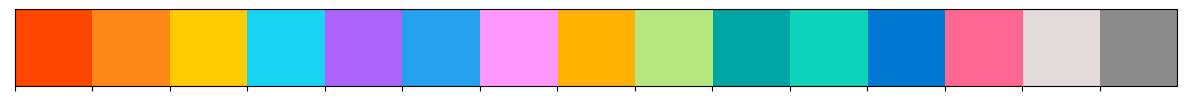

In [125]:
d_manual_label_colors = base_colors_for_manual_labels()
sns.palplot([v for v in d_manual_label_colors.values()])
check_colors_used(d_manual_label_colors, get_color_dict('dirl'))
check_colors_used(d_manual_label_colors, get_color_dict('plotly'))

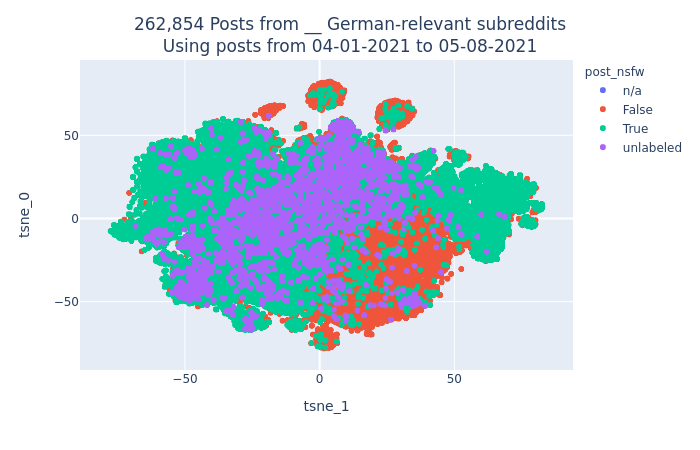

CPU times: user 1.53 s, sys: 40.3 ms, total: 1.57 s
Wall time: 3.77 s


In [196]:
%%time

fig = px.scatter(
    df_emb_svd2_meta,
    y='tsne_0', x='tsne_1',
    color='post_nsfw'
)
fig.update_layout(
    title_text=(
        f"{len(df_emb_svd2):,.0f} Posts from __ German-relevant subreddits"
        f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=900,
    height=700,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)

# fig.show()
fig.show(renderer='png')

## Language

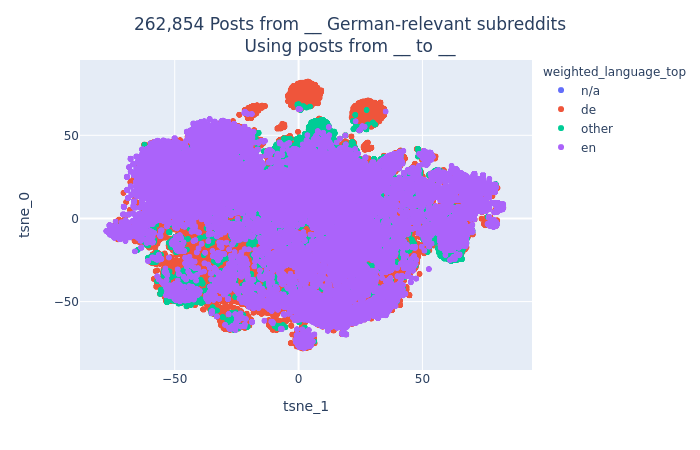

CPU times: user 1.56 s, sys: 44.7 ms, total: 1.61 s
Wall time: 3.72 s


In [194]:
%%time

fig = px.scatter(
    df_emb_svd2_meta,
    y='tsne_0', x='tsne_1',
    color='weighted_language_top'
)
fig.update_layout(
    title_text=(
        f"{len(df_emb_svd2):,.0f} Posts from __ German-relevant subreddits"
        f"<br>Using posts from __ to __"
    ),
    title_x=0.5,
    width=900,
    height=700,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
# fig.show()
fig.show(renderer='png')

## Category + sparse name

In [164]:
value_counts_and_pcts(df_emb_svd2[col_manual_labels])

,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,"142,092",54.1%,54.1%
uncategorized,"47,165",17.9%,72.0%
internet culture and memes,"25,714",9.8%,81.8%
place/culture,"22,339",8.5%,90.3%
podcasts and streamers,"5,675",2.2%,92.4%
reddit institutions,"3,534",1.3%,93.8%
sports,"3,472",1.3%,95.1%
"business, economics, and finance","2,792",1.1%,96.2%
"culture, entertainment, music","1,689",0.6%,96.8%
food and drink,"1,605",0.6%,97.4%


In [193]:
value_counts_and_pcts(df_posts[col_manual_labels], top_n=15)

,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,"142,092",54.2%,54.2%
uncategorized,"47,165",18.0%,72.2%
internet culture and memes,"25,714",9.8%,82.0%
place/culture,"22,339",8.5%,90.5%
podcasts and streamers,"5,675",2.2%,92.7%
reddit institutions,"3,534",1.3%,94.0%
sports,"3,472",1.3%,95.3%
"business, economics, and finance","2,792",1.1%,96.4%
"culture, entertainment, music","1,689",0.6%,97.0%
food and drink,"1,605",0.6%,97.7%


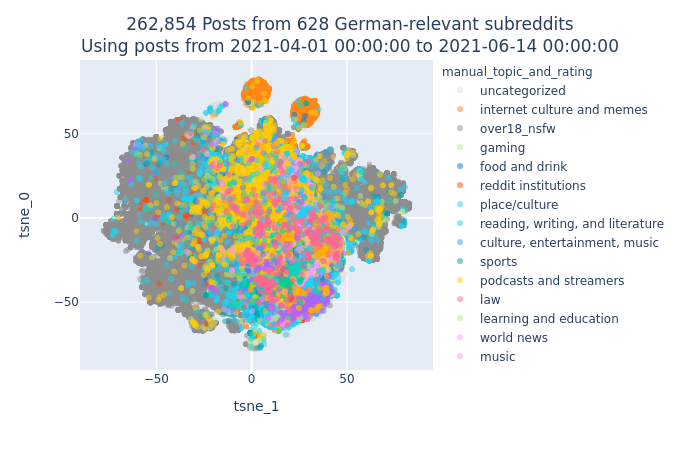

CPU times: user 3.78 s, sys: 64.5 ms, total: 3.85 s
Wall time: 7.52 s


In [191]:
%%time

# plot the name of the subreddit?

fig = px.scatter(
    (
        df_emb_svd2_meta[~df_emb_svd2_meta['post_id'].isnull()]
        # .sort_values(by=['subreddit_name_sparse_top'], ascending=True)
#         [['subreddit_name_sparse_top', 'tsne_0', 'tsne_1', col_manual_labels] + l_custom_data_posts]
    ),
    y='tsne_0', x='tsne_1',
    color=col_manual_labels,
    # text='subreddit_name_sparse_top',
    custom_data=l_custom_data_posts,
    color_discrete_map=d_manual_label_colors,
    # category_orders={col_manual_labels: list(df_post_label_count.index)},
    opacity=0.5,
)
# fig.update_traces(hovertemplate=posts_hover_data)
fig.update_layout(
    title_text=(
        f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
        f"<br>Using posts from {first_date} to {last_date}"
    ),
    title_x=0.5,
    width=1100,
    height=800,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

In [190]:
# %%time

# fig = px.scatter(
#     (
#         df_emb_svd2.sort_values(by=['subreddit_name_sparse_top'], ascending=True)
# #         [['subreddit_name_sparse_top', 'tsne_0', 'tsne_1', col_manual_labels] + l_custom_data_posts]
#     ),
#     y='tsne_0', x='tsne_1',
#     color=col_manual_labels,
#     text='subreddit_name_sparse_top',
#     custom_data=l_custom_data_posts,
#     color_discrete_map=d_manual_label_colors,
#     category_orders={col_manual_labels: list(df_post_label_count.index)},
#     opacity=0.5,
# )
# # fig.update_traces(hovertemplate=posts_hover_data)
# fig.update_layout(
#     title_text=(
#         f"{n_posts:,.0f} Posts from {n_subs} German-relevant subreddits"
#         f"<br>Using posts from {first_date} to {last_date}"
#     ),
#     title_x=0.5,
#     width=1100,
#     height=800,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show(renderer='png')
# # fig.show()